# Part-1 **Sentiment Analysis using BERT on Twitter US-Airlines Sentiment dataset **

The dataset I've chosen to perform sentiment analysis using a BERT model is the **Twitter US Airline sentiment dataset**.  The Twitter US Airline Sentiment dataset is a really popular dataset used in the field of natural language processing to analyze customer sentiment towards 6 major US airlines. The dataset is a collection of about 15000 tweets and were categorized by humans into 3 categories: Positive, Neutral and Negative.

This dataset is so popular because it reflects real-world sentiments expressed by actual customers of US airlines, providing a diverse and realistic range of opinions. Additionally, the dataset's large size and even distribution of sentiment categories make it a great choice for training and evaluating machine learning models for sentiment analysis. People have used this dataset to evaluate many different types of models, including traditional machine learning algorithms and advanced neural networks like BERT. Given that BERT has shown exceptional performance on various NLP tasks, it's a natural fit to apply it to the Twitter US Airline Sentiment dataset to see how well it performs on this specific task.

Dataset source: https://huggingface.co/datasets/osanseviero/twitter-airline-sentiment/viewer/osanseviero--twitter-airline-sentiment/train

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv('Tweets.csv')

In [52]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [53]:
# Check the shape of the dataset
print(df.shape)

(14640, 15)


In [54]:
# Check the columns of the dataset
print(df.columns)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [55]:
# Check the data types of the columns
print(df.dtypes)

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


In [56]:
# Check for missing values
print(df.isnull().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


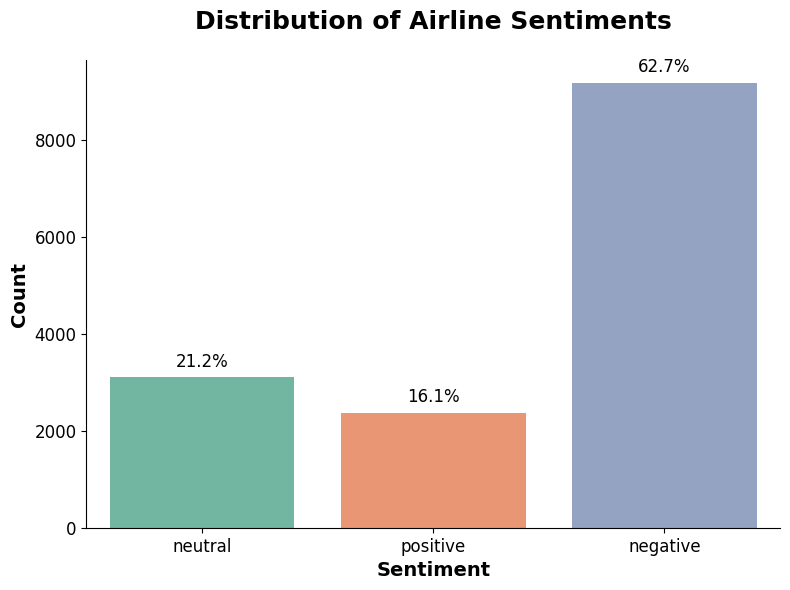

In [57]:
# Check the distribution of the target variable
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='airline_sentiment', palette='Set2')
plt.title('Distribution of Airline Sentiments', fontsize=18, fontweight='bold', y=1.05)
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{:.1f}%'.format(100 * height / len(df)), 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 5), textcoords='offset points', 
                ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

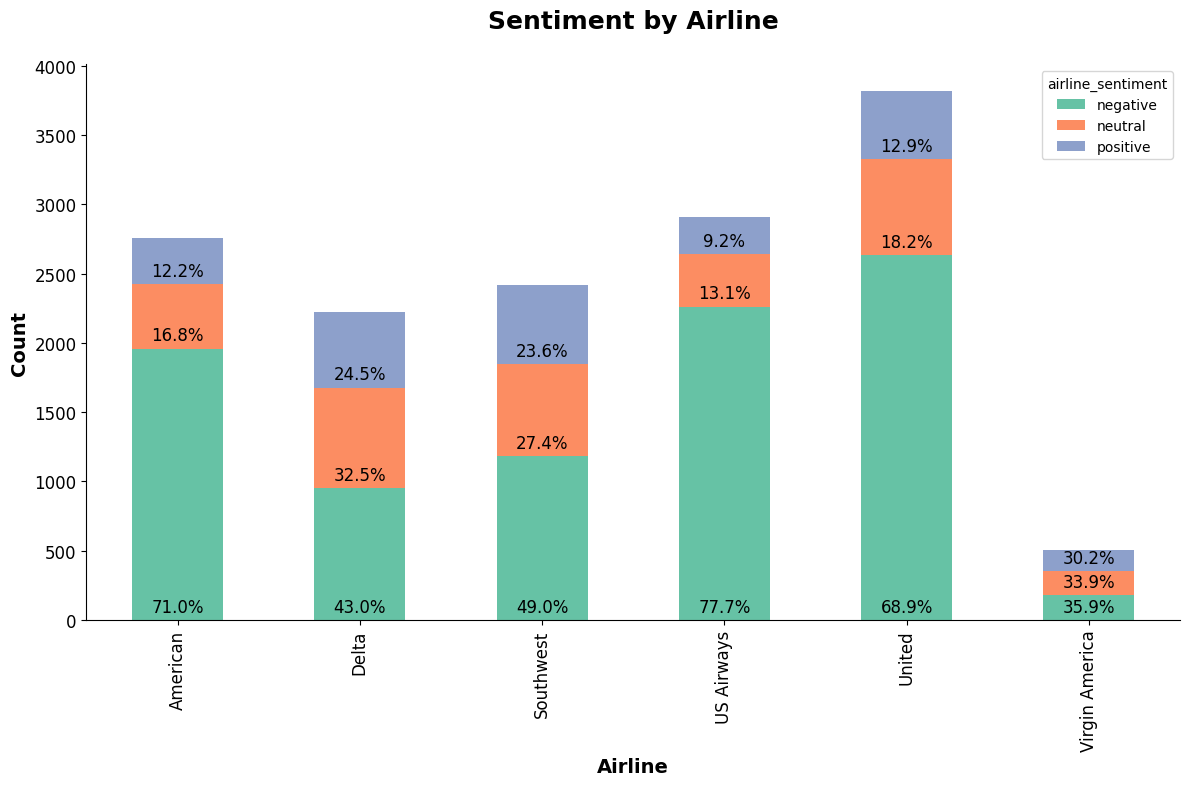

In [58]:
# Check the distribution of the sentiments by airline
airline_sentiment_counts = df.groupby(['airline', 'airline_sentiment']).size().unstack()

# Set color palette
colors = sns.color_palette('Set2')

# Create stacked bar chart
ax = airline_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12,8), color=colors)

# Customize plot
plt.title('Sentiment by Airline', fontsize=18, fontweight='bold', y=1.05)
plt.xlabel('Airline', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

# Add percentage labels
for i in range(len(airline_sentiment_counts)):
    total = sum(airline_sentiment_counts.iloc[i,:])
    for j in range(len(airline_sentiment_counts.columns)):
        percentage = airline_sentiment_counts.iloc[i,j]/total
        if percentage > 0.05:
            ax.annotate('{:.1%}'.format(percentage), 
            xy=(i, airline_sentiment_counts.iloc[i,:j].sum() + percentage/2), 
            xytext=(0, 3), textcoords='offset points',
            fontsize=12, color='black', ha='center', va='bottom')


plt.tight_layout()
plt.show()

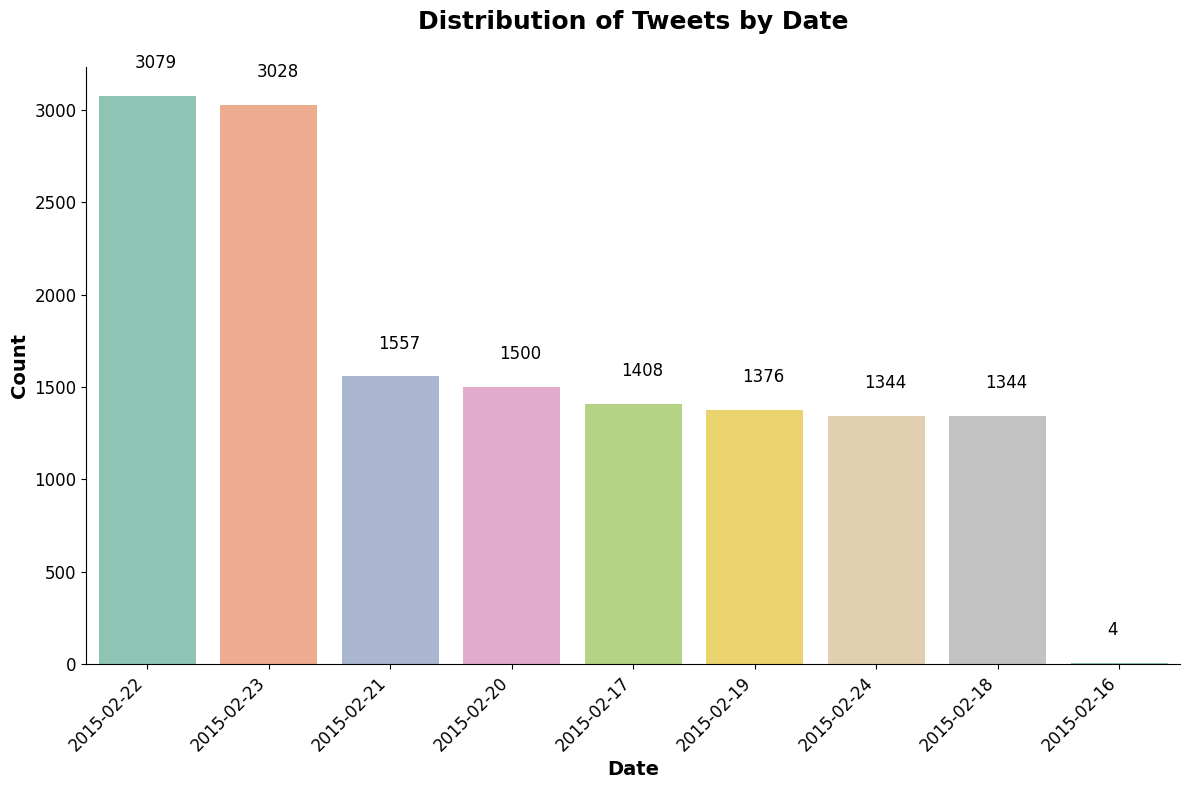

In [59]:
# Check the distribution of the sentiments over time
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df['date'] = df['tweet_created'].dt.date
df['hour'] = df['tweet_created'].dt.hour
date_counts = df['date'].value_counts()
hour_counts = df['hour'].value_counts()

# Plot distribution of tweets by date
plt.figure(figsize=(12,8))
ax = sns.barplot(x=date_counts.index, y=date_counts.values, alpha=0.8, palette='Set2')
plt.title('Distribution of Tweets by Date', fontsize=18, fontweight='bold', y=1.05)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
sns.despine()
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+0.3, p.get_height()+150), fontsize=12, color='black')
plt.tight_layout()
plt.show()

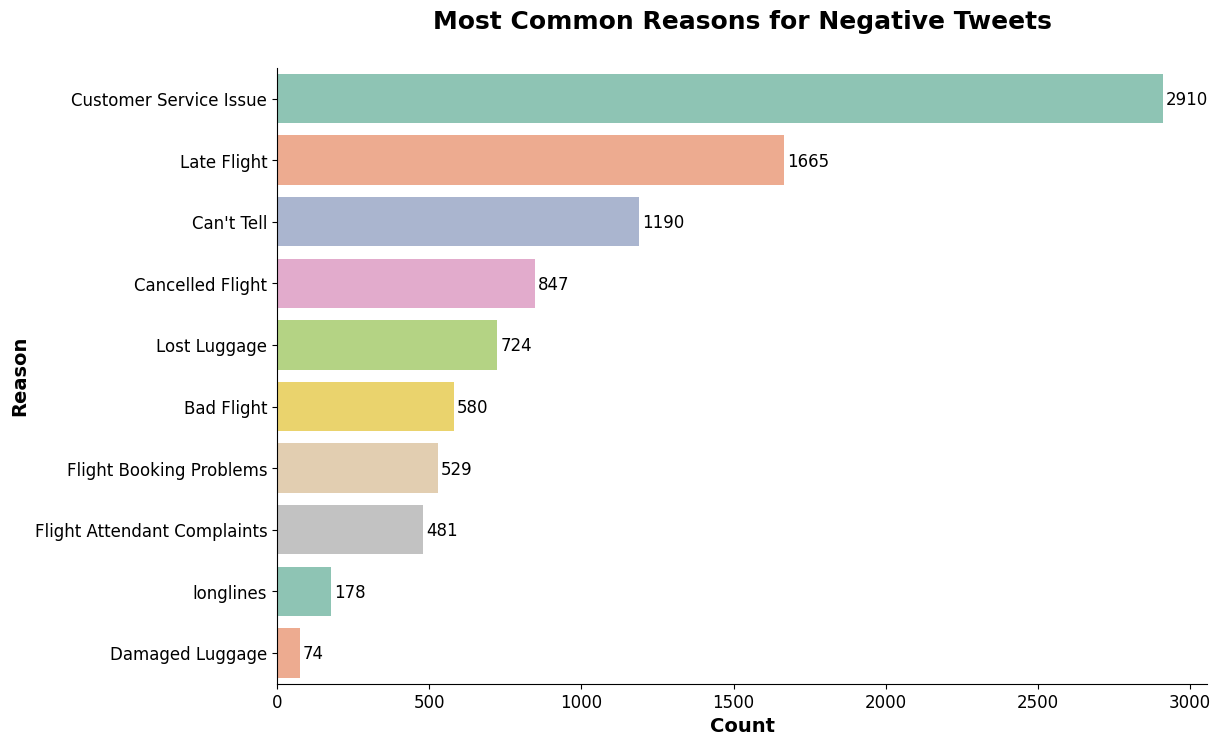

In [60]:
# Check the most common reasons for negative tweets
negative_tweets = df[df['airline_sentiment'] == 'negative']
negative_reason_counts = negative_tweets['negativereason'].value_counts()

# Set color palette
colors = sns.color_palette('Set2')

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=negative_reason_counts.values, y=negative_reason_counts.index, 
            alpha=0.8, palette=colors, ax=ax)

# Customize plot
ax.set_title('Most Common Reasons for Negative Tweets', fontsize=18, fontweight='bold', y=1.05)
ax.set_xlabel('Count', fontsize=14, fontweight='bold')
ax.set_ylabel('Reason', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
sns.despine()

# Add count labels
for i, v in enumerate(negative_reason_counts.values):
    ax.text(v+10, i+0.1, str(v), fontsize=12, color='black')

In [61]:
# Split data into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['airline_sentiment'], 
                                                                    random_state=2022, 
                                                                    test_size=0.2, 
                                                                    stratify=df['airline_sentiment'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2022, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Load pre-trained BERT tokenizer and encode text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_text.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_text.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_text.tolist(), truncation=True, padding=True)

df['airline_sentiment'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))

val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            torch.tensor(val_labels))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))


In [62]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [63]:
# Tensorizing the data using data loaders 
def get_data_loaders(train_inputs, train_labels, val_inputs, val_labels, batch_size):
    # Convert data to PyTorch tensors
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    val_inputs = torch.tensor(val_inputs)
    val_labels = torch.tensor(val_labels)
    
    # Create TensorDataset objects
    train_data = TensorDataset(train_inputs, train_labels)
    val_data = TensorDataset(val_inputs, val_labels)
    
    # Create DataLoader objects
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader

In [65]:
# Define data loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Set device to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Move model to the device
model = model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr= 1e-5, eps=1e-8)
num_warmup_steps = int(len(train_dataloader) * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=5)
epochs = 5

# Define cross-entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define early_stop
early_stop = 3
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_acc += (outputs[1].detach().cpu().numpy().argmax(axis=1) == b_labels.cpu().numpy()).mean()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Evaluation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            val_loss += loss.item()
            val_acc += (outputs[1].detach().cpu().numpy().argmax(axis=1) == b_labels.cpu().numpy()).mean()
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    print("Epoch {} - train loss: {:.3f} - train acc: {:.3f} - val loss: {:.3f} - val acc: {:.3f}".format(epoch, train_loss, train_acc, val_loss, val_acc))

    # Save the model
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'bert_sentiment_model.pt')
        best_val_loss = val_loss
        best_epoch = epoch
        print("The model has been saved")

    # Stop training if the validation loss stops improving after certain epochs
    if epoch - best_epoch >= early_stop:
        print("Validation loss has not improved in {} epochs, stopping training".format(early_stop))
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
Epoch 0 - train loss: 0.786 - train acc: 0.663 - val loss: 0.760 - val acc: 0.659
The model has been saved
Epoch 1 - train loss: 0.772 - train acc: 0.664 - val loss: 0.760 - val acc: 0.659
Epoch 2 - train loss: 0.771 - train acc: 0.662 - val loss: 0.760 - val acc: 0.659
Epoch 3 - train loss: 0.771 - train acc: 0.663 - val loss: 0.760 - val acc: 0.659
Validation loss has not improved in 3 epochs, stopping training


Experimenting with different batchizes, 64 batch size gave output in about 3 minutes for each epoch and had not much improvement in train accuracy.

32 batch size gave slightly improving acc, but converged in less than 3 epochs. Each epoch ran in about 7 mins. 

Now experimenting with 16 epochs. ~ 4 mins for each epoch.


**Observations for the (base) BERT model:**

The approach taken in this project involves fine-tuning a pre-trained BERT model for sentiment analysis on a Twitter airline dataset. The data is split into train, validation, and test sets, and the BERT tokenizer is used to encode the text inputs. The encoded inputs and corresponding labels are then fed into a BERT model, fine-tuned with the Adam optimizer and CrossEntropyLoss function, using a learning rate scheduler and early stopping for regularization. The model achieves a training accuracy of 66.3% and a validation accuracy of 65.9%, with a loss of 0.771 after 3 epochs. The results indicate that the model struggles to learn meaningful features from the data, and more complex architectures or further preprocessing may be necessary to improve performance.